# Image  Segmentation

Here we will show how semantic segmentation can be learned by a relatively simple neural network. This network includes 13 layers: 7 `Conv2D` and 6 `Conv2DTranspose`.

This code is adapted from the [Jupyter notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part01_image-segmentation.ipynb) of Chollet Deep Learning with Python, 2nd edition, chapter 9. It is presented here in accordance with the Apache v2 license. 

**The goal of the segmentation model would be to provide a pixel-level classification of whether the pixel is background, foreground or unclassified.**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import numpy as np
import random

In [3]:
input_dir = "../data/the_oxford_IIIT_pet_dataset/images/"
target_dir = "../data/the_oxford_IIIT_pet_dataset/annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

## Loading the Data to Memory

In [4]:
img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

### Defining the Model

**To the Student**: Notice the `strides` value of each layer. 
* How many types of strides are there for `Conv2D`? And for `Conv2DTranspose`?
* Based on the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) what is the default `strides` value for `Conv2DTranspose`?
* Based on the model summary, how does the spatial dimension change when `strides=1` and `2`, for `Conv2DTranspose`?
* How many predictions are being made at the last layer? 

In [5]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

### Training the Model
**Note: the cell below will run for about 12 hours on a CPU.**

In [6]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("./models/oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 1383s 14s/step - loss: 0.9454 - val_loss: 0.9027
Epoch 2/50
100/100 [==============================] - 1353s 14s/step - loss: 0.8756 - val_loss: 0.8186
Epoch 3/50
100/100 [==============================] - 1314s 13s/step - loss: 0.8306 - val_loss: 0.8305
Epoch 4/50
100/100 [==============================] - 1300s 13s/step - loss: 0.8118 - val_loss: 0.8030
Epoch 5/50
100/100 [==============================] - 1293s 13s/step - loss: 0.7741 - val_loss: 0.7405
Epoch 6/50
100/100 [==============================] - 1286s 13s/step - loss: 0.7559 - val_loss: 0.7761
Epoch 7/50
100/100 [==============================] - 1285s 13s/step - loss: 0.7511 - val_loss: 0.7101
Epoch 8/50
100/100 [==============================] - 1287s 13s/step - loss: 0.7271 - val_loss: 0.6983
Epoch 9/50
100/100 [==============================] - 1281s 13s/step - loss: 0.7117 - val_loss: 0.7702
Epoch 10/50
100/100 [==============================] - 1281s 13s/step - l

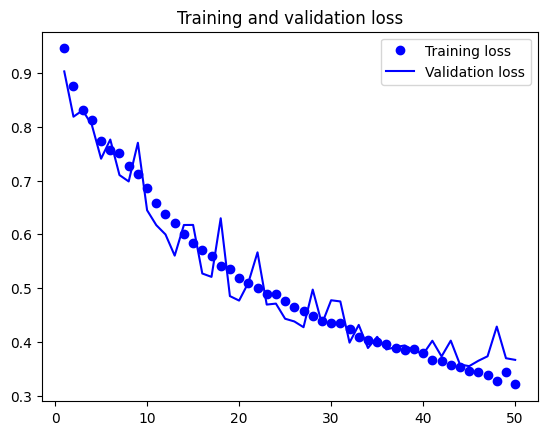

In [7]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

### Testing the Model

In [56]:
# choosing a random test image
i = 1
test_image = val_input_imgs[i]
ground_truth_mask = (val_targets[i])

In [57]:
# load the model
model = keras.models.load_model("./models/oxford_segmentation.keras")

In [58]:
# run a prediction on the test image
mask = model.predict(np.expand_dims(test_image, 0))[0]  # mask is the prediction of the model.

1/1 [==============================] - 0s 234ms/step


In [59]:
print(ground_truth_mask.shape)
print(mask.shape)

(200, 200, 1)
(200, 200, 3)


In [60]:
# convert mask to 2d array by taking the argmax of the predictions
mask_reshaped = np.argmax(mask, axis=-1)
print(mask_reshaped.shape)
# extend the dimensions of the mask to be 3d - 
# this is actually not needed for visualization
# and done here just so that the shape is the same as the target, for esthetics only
mask_reshaped = np.expand_dims(mask_reshaped, -1)
print(mask_reshaped.shape)


(200, 200)
(200, 200, 1)


In [61]:
# print the predicted and ground truth classification label
print(np.unique(np.round(mask_reshaped)))
print(np.unique(ground_truth_mask))

[0 1 2]
[0 1 2]


#### Visually Compare Results

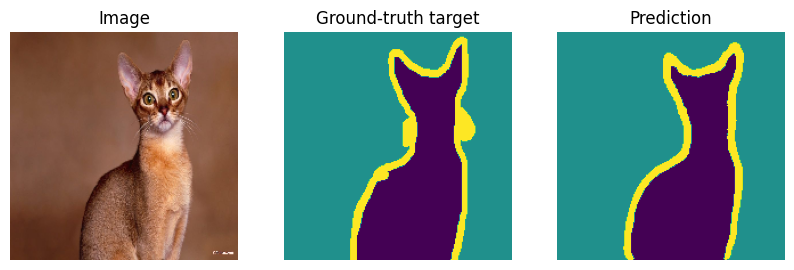

In [62]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.subplot(1, 3, 2)
plt.title("Ground-truth target")
plt.axis("off")
plt.imshow(ground_truth_mask)
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.axis("off")
plt.imshow(mask_reshaped)


#### Manually validating the color scheme

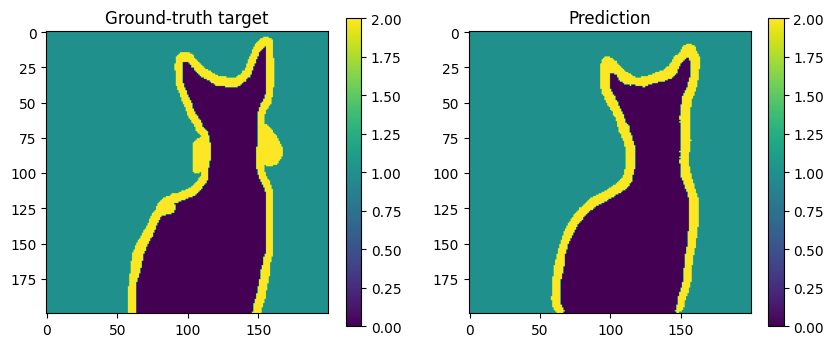

In [63]:
# show a color legend
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Ground-truth target")
plt.imshow(ground_truth_mask)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(mask_reshaped)
plt.colorbar()


## Intersection over Union (IoU)
In image segmentation, a common performance metric to evaluate the model is Intersection over Union (IoU), also known as the Jaccard index. IoU measures the overlap between the predicted 
segmentation mask and the ground truth mask. It is calculated as the ratio of the intersection of the predicted and ground truth masks to the union of the predicted and ground truth masks. 


In [64]:
# implement the intersection over union metric using tf.keras.metrics.IoU
# reference: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/IoU

from tensorflow.keras.metrics import MeanIoU

n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(ground_truth_mask, mask_reshaped)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.8407941


**To the Student**: 
1. Test various images
2. The three classes here include a 'boundary' class indicating the intermediate region between the background and the target object. For the purpose of IoU, at least for certain images, it is insightful to calculate IoU over just two classes. Update the target and predicted mask such that there are just two classes (taking the 'boundary' class to either background class or object class), and calculate IoU. 
